In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skopt
from tqdm import tqdm
import shutil
import glob
import dill

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = 69392#np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

69392


In [5]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir/{DEFAULT_RANDOM_SEED}'

In [6]:
if not os.path.isdir(temp_work_dir):
    os.mkdir(temp_work_dir)
    dat_files = glob.glob(f'{orig_work_dir}/*.dat')
    for df in dat_files:
        shutil.copy(df, temp_work_dir)

In [7]:
os.chdir(temp_work_dir)

In [8]:
input_beam_path = "primary_optics_system_beam.dat"

In [9]:
move_motors = ['vkb_4', 'hkb_4']

In [10]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [11]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

9.483920491356152e-05


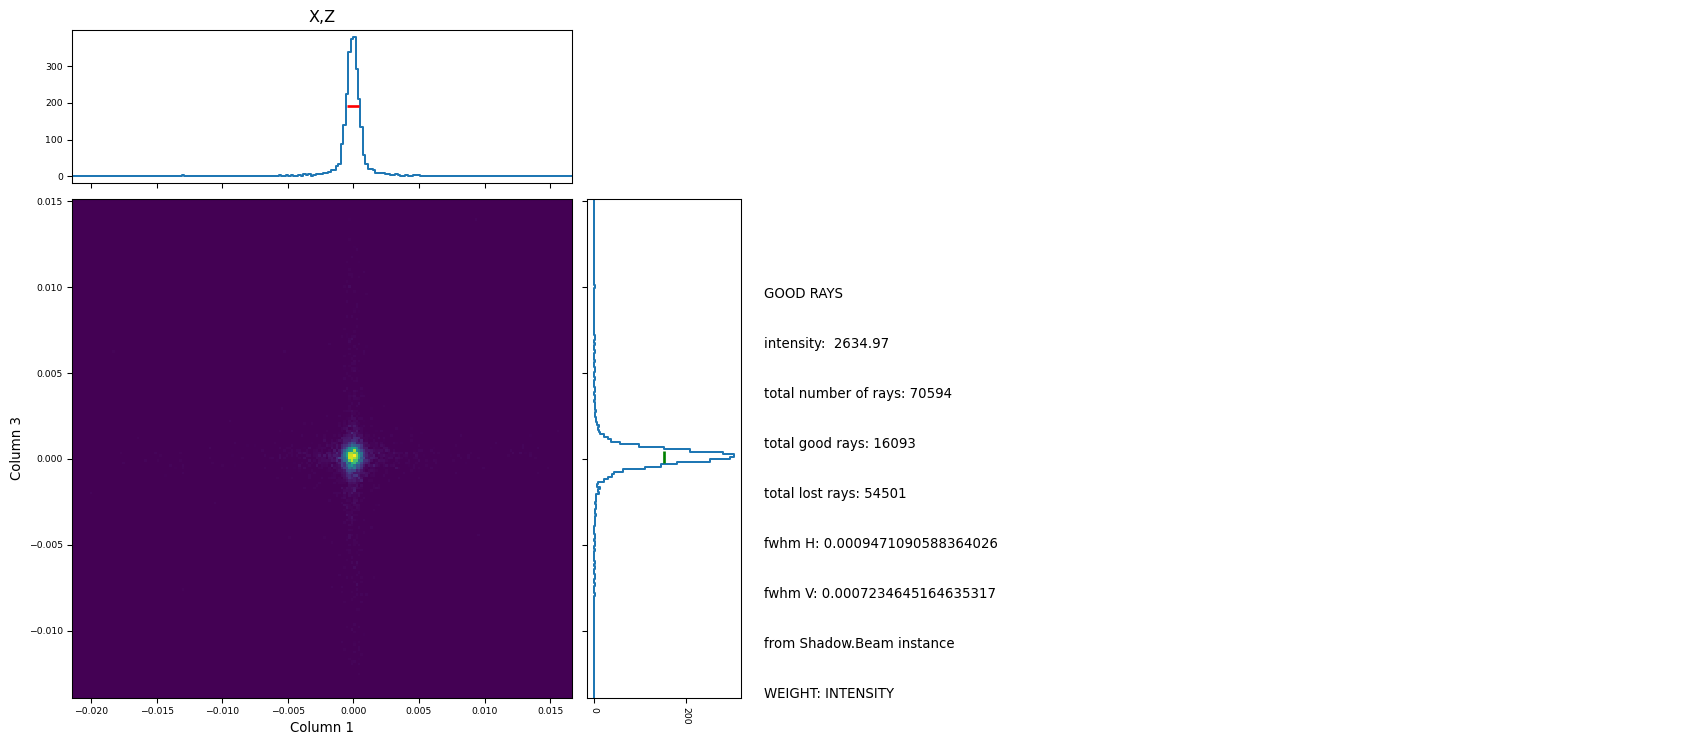

In [12]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [13]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0. 0.]


In [14]:
# Plotting the loss function for a grid of values

In [15]:
move_motors

['vkb_4', 'hkb_4']

In [16]:
test_hkb_4 = np.linspace(-0.14, 0.14, 6)
test_vkb_4 = test_hkb_4
centroid_values = []
for v in tqdm(test_vkb_4):
    for h in (test_hkb_4):
        focusing_system = movers.move_motors(focusing_system, move_motors, [v, h], movement='relative')
        centroid_distance, out_beam, *_ = opt_common.get_centroid_distance(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED)
        focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')
        centroid_values.append(centroid_distance)

100%|██████████| 6/6 [01:50<00:00, 18.37s/it]


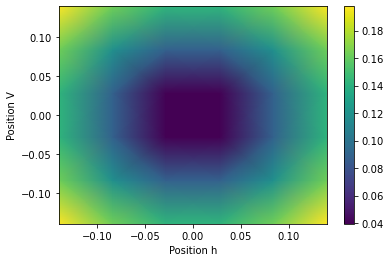

In [20]:
xvals = test_hkb_4 + initial_absolute_positions[1]
yvals = test_vkb_4 + initial_absolute_positions[0]

xx, yy = np.meshgrid(xvals, yvals)

#plt.plot(test_values + initial_absolute_positions[0], fwhm_values)
plt.pcolormesh(xx, yy, np.reshape(centroid_values, (6,6)), shading='gouraud')
plt.xlabel('Position h')
plt.ylabel('Position V')
plt.colorbar()
plt.show()

In [21]:
N_RUNS = 5

min_trans = -0.14
max_trans = 0.14

#### Trying out joint optimization with scipy

In [ ]:
%%time
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all_scipy = []



for outer in tqdm(range(N_RUNS)):
    translations = np.random.uniform(min_trans, max_trans, size=2)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='centroid',
                                              default_opt_params={'maxfev':100,
                                                                  'fatol': 1e-4, 
                                                                  'disp': True})
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(centroid)
    final_out_beams.append(out_beam)
    opt_results_all_scipy.append(opt_results)
    print(f'Test {outer} success {success} with final x {opt_results[-1].x} and final value {opt_results[-1].fun}')

  0%|          | 0/5 [00:00<?, ?it/s]

Initial motor positions are [ 0.06435251 -0.02236745]
Initial loss is 0.0679274364164133
initial guess is [-0.06865277 -0.0366918 ]
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 28
         Function evaluations: 54


 20%|██        | 1/5 [03:04<12:19, 184.76s/it]

Test 0 success True with final x [-0.06438303  0.02232923] and final value 4.769475400370923e-05
Initial motor positions are [-0.05919984 -0.02763221]
Initial loss is 0.0650008232577076
initial guess is [ 0.00842609 -0.04583371]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 37
         Function evaluations: 72


 40%|████      | 2/5 [07:08<10:57, 219.19s/it]

Test 1 success True with final x [0.05911101 0.02756869] and final value 1.750218707442562e-05
Initial motor positions are [ 0.02226906 -0.13370602]
Initial loss is 0.13528881403667387
initial guess is [ 0.11070024 -0.05094994]
Initial loss is 0.13528881403667387
Initial guess [ 0.06995231 -0.11930109] produces beam out of bounds. Trying another guess.
initial guess is [ 0.09844595 -0.00230517]


In [85]:
with open('final_scipy_simul_beams/opt_results_all_scipy.pkl', 'wb') as f:
    dill.dump(opt_results_all_scipy, f)

In [51]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [52]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [53]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [54]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

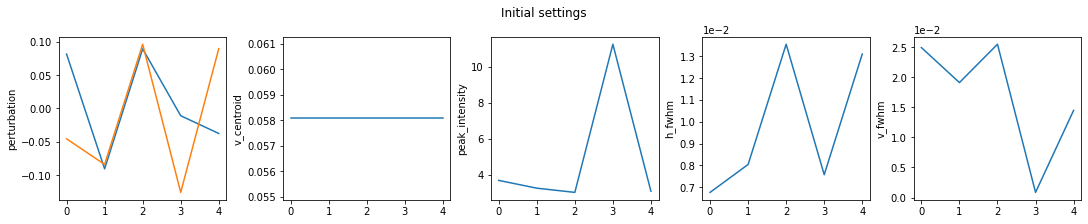

In [55]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_losses)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

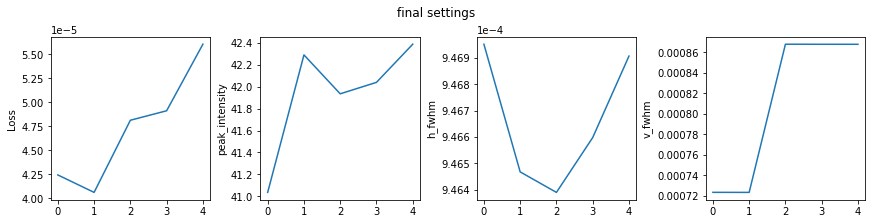

In [56]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_losses)
axes[0].set_ylabel('Loss')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

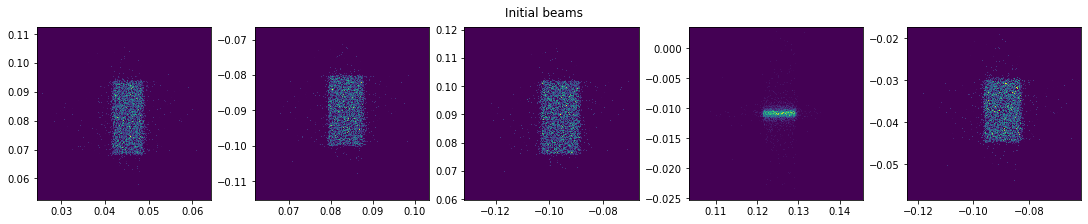

In [61]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

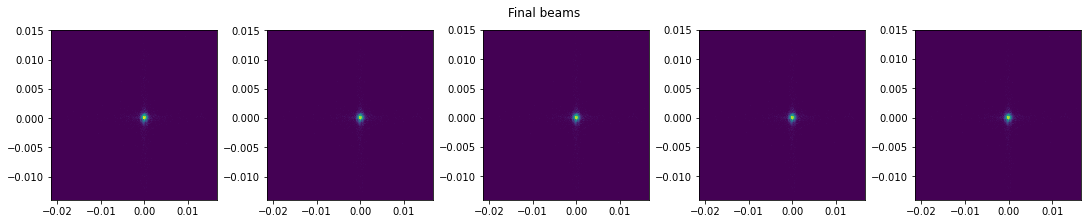

In [62]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [63]:
absolute_movements

[array([ 0.08153128, -0.04539434]),
 array([-0.09036973, -0.08380041]),
 array([0.08939178, 0.09628829]),
 array([-0.0108506 , -0.12566181]),
 array([-0.03739743,  0.08965405])]

#### Reloading scipy optimization results

In [41]:
with open('final_scipy_simul_beams/opt_results_all_scipy.pkl', 'rb') as f:
    scipy_opt_results_all = dill.load(f)

In [46]:
nfevals = []
func_vals = []
for sr_per_guess in scipy_opt_results_all:
    nfevals.append(sum([sr['nfev'] for sr in sr_per_guess]))
    func_vals.append(sr_per_guess[-1]['fun'])

In [47]:
nfevals, func_vals

([67, 79, 61, 84, 69],
 [3.978828118594534e-05,
  4.025923322579147e-05,
  3.721591933015535e-05,
  3.883230354795503e-05,
  5.607357915637893e-05])

#### Test joint gaussian process optimization

In [59]:
focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         absolute_movements[0],
                                         movement='absolute')

In [62]:
??plot_shadow_beam_spatial_distribution

Signature:
plot_shadow_beam_spatial_distribution(
    shadow_beam,
    nbins=201,
    nolost=1,
    title='X,Z',
    xrange=None,
    yrange=None,
)
Docstring: <no docstring>
Source:   
def plot_shadow_beam_spatial_distribution(shadow_beam, nbins=201, nolost=1, title="X,Z", xrange=None, yrange=None):
    return Shadow.ShadowTools.plotxy(shadow_beam._beam, 1, 3, nbins=nbins, nolost=nolost, title=title, xrange=xrange, yrange=yrange)
File:      /gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/beamline34IDC/util/shadow/common.py
Type:      function


In [63]:
test_out_beam = focusing_system.get_photon_beam(random_seed=DEFAULT_RANDOM_SEED)

In [64]:
hist, dw = get_shadow_beam_spatial_distribution(test_out_beam)

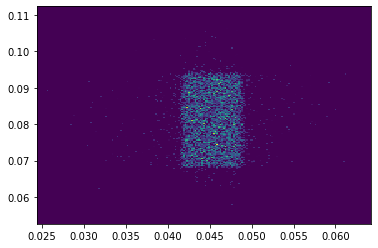

In [66]:
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)

In [55]:
callback_y = skopt.callbacks.DeltaYStopper(1e-5)
callback_x = skopt.callbacks.DeltaXStopper(1e-5)

In [85]:
%%time

start_guesses_gp = []
overall_successes_gp = []
final_losses_gp = []
final_out_beams_gp = []
opt_results_all_gp = []

min_trans = -0.14
max_trans = 0.14

for outer, test_absolute_movements in tqdm(enumerate(absolute_movements)):
    print("Initial motor positions are", test_absolute_movements)
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='centroid', 
                                              loss_min_value=1e-3)
    bounds = []
    for m in test_absolute_movements:
        bounds_this = [min_trans - m - 0.02, max_trans - m + 0.02]
        bounds.append(bounds_this)
    print('Bounds are', bounds)
    opt_trial.set_gaussian_process_optimizer(bounds=bounds, callback=[callback_x, callback_y])
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=0., guess_max=0.0)
    focusing_system = opt_trial.focusing_system
    
    start_guesses_gp.append(guesses)
    overall_successes_gp.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    final_losses_gp.append(centroid)
    final_out_beams_gp.append(out_beam)
    opt_results_all_gp.append(opt_results)
    print(f'Test {outer} success {success} with final x {opt_results[-1].x} and final value {opt_results[-1].fun}')

0it [00:00, ?it/s]

Initial motor positions are [ 0.08153128 -0.04539434]
Bounds are [[-0.24153128, 0.07846872000000002], [-0.11460566000000001, 0.20539434]]
Initial loss is 0.09301584326050917
motors ['vkb_4', 'hkb_4'] trans [-0.1455665   0.19607158] current loss 0.16056084880859348
motors ['vkb_4', 'hkb_4'] trans [-0.17381685  0.13647631] current loss 0.12916050908958027
motors ['vkb_4', 'hkb_4'] trans [0.03176717 0.12116359] current loss 0.1358240133596474
motors ['vkb_4', 'hkb_4'] trans [-0.02052418  0.17910895] current loss 0.1460890731137437
motors ['vkb_4', 'hkb_4'] trans [-0.11567933 -0.01122587] current loss 0.06591319147354147
motors ['vkb_4', 'hkb_4'] trans [ 0.04024797 -0.0318242 ] current loss 0.14379334192282472
motors ['vkb_4', 'hkb_4'] trans [-0.07992922  0.05980748] current loss 0.014541062821959966
motors ['vkb_4', 'hkb_4'] trans [-0.00617525  0.12101847] current loss 0.10642874638896312
motors ['vkb_4', 'hkb_4'] trans [-0.21285161  0.16996132] current loss 0.18025891763108856
motors ['v

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.07846872 -0.11460566] current loss 0.22579422087008158
motors ['vkb_4', 'hkb_4'] trans [-0.07689994  0.04061464] current loss 0.0066893215033026815
motors ['vkb_4', 'hkb_4'] trans [-0.24153128  0.01878447] current loss 0.16141771705479227


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.07846872 0.20539434] current loss 0.23666629497215072
motors ['vkb_4', 'hkb_4'] trans [-0.04674211  0.02910318] current loss 0.03831429711376411


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.07846872 0.04362117] current loss 0.159543750504423
motors ['vkb_4', 'hkb_4'] trans [-0.0830134   0.05224982] current loss 0.0070523229979147575
motors ['vkb_4', 'hkb_4'] trans [-0.08981399  0.03281191] current loss 0.015018446814765529
motors ['vkb_4', 'hkb_4'] trans [-0.0834685  0.0465676] current loss 0.0022556483769116437
motors ['vkb_4', 'hkb_4'] trans [-0.08386693  0.0417784 ] current loss 0.004224675567097491
motors ['vkb_4', 'hkb_4'] trans [-0.24153128  0.09273659] current loss 0.1660369670529809
motors ['vkb_4', 'hkb_4'] trans [-0.08384499  0.04029893] current loss 0.005519005763292183
motors ['vkb_4', 'hkb_4'] trans [-0.08380038  0.03976164] current loss 0.005995852794720685
motors ['vkb_4', 'hkb_4'] trans [-0.08376183  0.04027606] current loss 0.005506232959082705
motors ['vkb_4', 'hkb_4'] trans [-0.21060914 -0.04489851] current loss 0.15687988481143536
motors ['vkb_4', 'hkb_4'] trans [-0.07198946 -0.11460566] current loss 0.159969254551432

1it [04:10, 250.93s/it]

Test 0 success True with final x [-0.08121968300116728, 0.04587968990492654] and final value 0.0006685249676003145
Initial motor positions are [-0.09036973 -0.08380041]
Bounds are [[-0.06963027000000002, 0.25036973], [-0.07619959000000001, 0.24380041]]
Initial loss is 0.12281321578194175
motors ['vkb_4', 'hkb_4'] trans [0.2207641 0.2280678] current loss 0.19342387765348162
motors ['vkb_4', 'hkb_4'] trans [0.22413464 0.11588181] current loss 0.1369572112827265
motors ['vkb_4', 'hkb_4'] trans [-0.00067076  0.18011379] current loss 0.13198871418262925
motors ['vkb_4', 'hkb_4'] trans [ 0.0142928  -0.05984646] current loss 0.1621693601964743
motors ['vkb_4', 'hkb_4'] trans [0.16964033 0.08284315] current loss 0.07900146386751235
motors ['vkb_4', 'hkb_4'] trans [0.0811088  0.16440148] current loss 0.08090651662628918
motors ['vkb_4', 'hkb_4'] trans [0.12730475 0.22787844] current loss 0.14775030012611853
motors ['vkb_4', 'hkb_4'] trans [ 0.07885559 -0.00422406] current loss 0.088610672429694

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.25036973 -0.07619959] current loss 0.22579422087008155
motors ['vkb_4', 'hkb_4'] trans [0.0870788  0.07606477] current loss 0.008336427495506993
motors ['vkb_4', 'hkb_4'] trans [-0.06963027  0.06879022] current loss 0.15992096948102305
motors ['vkb_4', 'hkb_4'] trans [0.08551756 0.07403853] current loss 0.010837506086031543
motors ['vkb_4', 'hkb_4'] trans [-0.06963027  0.24380041] current loss 0.21638417163352694
motors ['vkb_4', 'hkb_4'] trans [0.08727824 0.07746794] current loss 0.00697243017109835
motors ['vkb_4', 'hkb_4'] trans [-0.06948262 -0.07293397] current loss 0.22320665244919297
motors ['vkb_4', 'hkb_4'] trans [ 0.13584484 -0.07469576] current loss 0.1645180162562213
motors ['vkb_4', 'hkb_4'] trans [0.08746271 0.07922463] current loss 0.00534532812551648
motors ['vkb_4', 'hkb_4'] trans [0.10346331 0.08671946] current loss 0.0135887567632079
motors ['vkb_4', 'hkb_4'] trans [0.08581913 0.08046277] current loss 0.005581449114374502
motors ['v

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.25036973 0.04321388] current loss 0.16457198471975856
motors ['vkb_4', 'hkb_4'] trans [0.09285796 0.08382976] current loss 0.0025806161488817463
motors ['vkb_4', 'hkb_4'] trans [0.09141754 0.08469175] current loss 0.0014750357718542328
motors ['vkb_4', 'hkb_4'] trans [0.09162466 0.08513124] current loss 0.001931612948683681
motors ['vkb_4', 'hkb_4'] trans [0.0494896  0.24380041] current loss 0.1574320006038661
motors ['vkb_4', 'hkb_4'] trans [0.09139748 0.08469549] current loss 0.001461317506977985
motors ['vkb_4', 'hkb_4'] trans [0.09141913 0.08483224] current loss 0.0015708733580343567
motors ['vkb_4', 'hkb_4'] trans [0.0912461  0.08459126] current loss 0.001280127494442497
motors ['vkb_4', 'hkb_4'] trans [0.09139962 0.08497291] current loss 0.0016576124908987157
motors ['vkb_4', 'hkb_4'] trans [0.00076471 0.10106709] current loss 0.09083291915431267
motors ['vkb_4', 'hkb_4'] trans [0.09116841 0.08432171] current loss 0.0010541547743085633
motors ['

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.25036973 0.17472822] current loss 0.18358017840915467
motors ['vkb_4', 'hkb_4'] trans [0.09039175 0.08315478] current loss 0.0005907932817204891
motors ['vkb_4', 'hkb_4'] trans [-0.02169467  0.24380041] current loss 0.1882300624440366
motors ['vkb_4', 'hkb_4'] trans [0.07654618 0.07974943] current loss 0.014455037712708277
motors ['vkb_4', 'hkb_4'] trans [0.07331955 0.0397839 ] current loss 0.04714195288660548
motors ['vkb_4', 'hkb_4'] trans [0.09039492 0.08312558] current loss 0.0006202098400817271
motors ['vkb_4', 'hkb_4'] trans [0.09039146 0.08309945] current loss 0.0006453489986359893
motors ['vkb_4', 'hkb_4'] trans [0.11181498 0.0689657 ] current loss 0.02596615102291034
motors ['vkb_4', 'hkb_4'] trans [0.09039151 0.08309669] current loss 0.0006479106336830764
motors ['vkb_4', 'hkb_4'] trans [0.09039169 0.08308533] current loss 0.0006597074352821425
motors ['vkb_4', 'hkb_4'] trans [0.09039266 0.0830782 ] current loss 0.0006663289158274685
Loss is

2it [09:42, 298.19s/it]

Test 1 success True with final x [0.09048268648054913, 0.08332255803413557] and final value 0.00045334371634441915
Initial motor positions are [0.08939178 0.09628829]
Bounds are [[-0.24939178, 0.07060822000000001], [-0.25628829000000003, 0.06371171000000002]]
Initial loss is 0.130914176391395
motors ['vkb_4', 'hkb_4'] trans [-0.09764693 -0.13035185] current loss 0.0349704114579879
motors ['vkb_4', 'hkb_4'] trans [ 0.0389271  -0.12480747] current loss 0.13088723752931322
motors ['vkb_4', 'hkb_4'] trans [-0.12534814  0.03684443] current loss 0.1371343262522726
motors ['vkb_4', 'hkb_4'] trans [ 0.00136205 -0.05260172] current loss 0.10037001920701194
motors ['vkb_4', 'hkb_4'] trans [ 0.056012   -0.13917248] current loss 0.15080582461925832
motors ['vkb_4', 'hkb_4'] trans [-0.07644132 -0.11271128] current loss 0.020973809425992817
motors ['vkb_4', 'hkb_4'] trans [-0.12218104  0.0370488 ] current loss 0.1364720867994087
motors ['vkb_4', 'hkb_4'] trans [-0.19578355 -0.10228835] current loss 

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.07060822 0.06371171] current loss 0.23666722511763816
motors ['vkb_4', 'hkb_4'] trans [-0.09040512 -0.0961703 ] current loss 0.0009686419010392922
motors ['vkb_4', 'hkb_4'] trans [-0.10425676 -0.25628829] current loss 0.1603722503069766
motors ['vkb_4', 'hkb_4'] trans [-0.09315295 -0.10510128] current loss 0.0095111321466866


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.07060822 -0.25628829] current loss 0.2257934284722094
motors ['vkb_4', 'hkb_4'] trans [-0.24939178  0.06371171] current loss 0.21638417163352716
motors ['vkb_4', 'hkb_4'] trans [-0.08971587 -0.09131893] current loss 0.005032615284479046
motors ['vkb_4', 'hkb_4'] trans [-0.08904703 -0.09387516] current loss 0.0025088299139433435
motors ['vkb_4', 'hkb_4'] trans [-0.08886028 -0.09390887] current loss 0.0025150903623836623
motors ['vkb_4', 'hkb_4'] trans [-0.12970126 -0.1746192 ] current loss 0.08784050840279567
motors ['vkb_4', 'hkb_4'] trans [-0.09032006 -0.02500355] current loss 0.0710913527849772
motors ['vkb_4', 'hkb_4'] trans [-0.24939178 -0.1328534 ] current loss 0.16335428509735508
motors ['vkb_4', 'hkb_4'] trans [-0.03739066  0.06371171] current loss 0.16145842449447242
motors ['vkb_4', 'hkb_4'] trans [-0.08803021 -0.0951518 ] current loss 0.0018786364713476115


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.07060822 -0.0534556 ] current loss 0.16519672559722853
motors ['vkb_4', 'hkb_4'] trans [-0.08786906 -0.09524009] current loss 0.001955428770985826
motors ['vkb_4', 'hkb_4'] trans [-0.08747386 -0.09550451] current loss 0.0021778395290294153
motors ['vkb_4', 'hkb_4'] trans [-0.08716499 -0.09587416] current loss 0.002367361437006799
motors ['vkb_4', 'hkb_4'] trans [-0.05617459 -0.16065122] current loss 0.07226930378916636
motors ['vkb_4', 'hkb_4'] trans [-0.09200877 -0.09696387] current loss 0.0026455227641043765
motors ['vkb_4', 'hkb_4'] trans [-0.08716053 -0.09775592] current loss 0.0027153785570613524
motors ['vkb_4', 'hkb_4'] trans [-0.08991757 -0.09679438] current loss 0.0006398639907881899
motors ['vkb_4', 'hkb_4'] trans [-0.08996473 -0.09697076] current loss 0.0008026737102025698
motors ['vkb_4', 'hkb_4'] trans [-0.09037552 -0.09697101] current loss 0.001110399292320486
motors ['vkb_4', 'hkb_4'] trans [-0.09072064 -0.09689706] current loss 0.0013

3it [14:48, 301.77s/it]

Test 2 success True with final x [-0.08991756775251339, -0.09679438395448675] and final value 0.0006398639907881899
Initial motor positions are [-0.0108506  -0.12566181]
Bounds are [[-0.14914940000000002, 0.1708506], [-0.034338190000000005, 0.28566181]]
Initial loss is 0.12594808784728376
motors ['vkb_4', 'hkb_4'] trans [-0.03154718  0.08661614] current loss 0.057381320117099656
motors ['vkb_4', 'hkb_4'] trans [0.12242756 0.09694267] current loss 0.11476241377876267
motors ['vkb_4', 'hkb_4'] trans [0.01462404 0.11877692] current loss 0.007849064788974139
motors ['vkb_4', 'hkb_4'] trans [-0.12324595 -0.00908171] current loss 0.1895092932226157
motors ['vkb_4', 'hkb_4'] trans [-0.05996901  0.02537629] current loss 0.12240239846599953
motors ['vkb_4', 'hkb_4'] trans [-0.09232777  0.01247687] current loss 0.15268757792928425
motors ['vkb_4', 'hkb_4'] trans [-0.06462316  0.04239929] current loss 0.11199597452117065
motors ['vkb_4', 'hkb_4'] trans [-0.00602002  0.03799307] current loss 0.089

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.1708506  0.28566181] current loss 0.2366662949721498
motors ['vkb_4', 'hkb_4'] trans [-0.1491494   0.23943421] current loss 0.1954395535207726
motors ['vkb_4', 'hkb_4'] trans [0.01179837 0.10694637] current loss 0.018695890145124603


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.1708506  -0.03433819] current loss 0.22579422087008108
motors ['vkb_4', 'hkb_4'] trans [-0.05166612  0.15369545] current loss 0.06817508330920388
motors ['vkb_4', 'hkb_4'] trans [0.00927069 0.12462196] current loss 0.0018073309283333627
motors ['vkb_4', 'hkb_4'] trans [ 0.04427373 -0.03412938] current loss 0.16294019804030904
motors ['vkb_4', 'hkb_4'] trans [0.00944331 0.12526318] current loss 0.0013891743299269035
motors ['vkb_4', 'hkb_4'] trans [-0.14894485  0.11257494] current loss 0.15948165341561557
motors ['vkb_4', 'hkb_4'] trans [0.00880039 0.12608347] current loss 0.00205805940978952
motors ['vkb_4', 'hkb_4'] trans [0.00777064 0.12735758] current loss 0.003508430697431575
motors ['vkb_4', 'hkb_4'] trans [0.06524288 0.22285263] current loss 0.1110074961506112
motors ['vkb_4', 'hkb_4'] trans [0.04209322 0.08228065] current loss 0.05332716522345425
motors ['vkb_4', 'hkb_4'] trans [0.04398075 0.14916422] current loss 0.040521228853636966
motors [

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.1708506 0.189157 ] current loss 0.17170150620997782


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.17022346 0.06925429] current loss 0.16898063118220302
motors ['vkb_4', 'hkb_4'] trans [0.00760542 0.12691615] current loss 0.003464873063844115
motors ['vkb_4', 'hkb_4'] trans [0.00860041 0.1272451 ] current loss 0.002745000277559992
motors ['vkb_4', 'hkb_4'] trans [0.00819859 0.12307042] current loss 0.003633705506022265
motors ['vkb_4', 'hkb_4'] trans [-0.01746511  0.19831224] current loss 0.07773087467764495
motors ['vkb_4', 'hkb_4'] trans [0.00939955 0.12494073] current loss 0.0015394377698530067
motors ['vkb_4', 'hkb_4'] trans [0.00935881 0.12458581] current loss 0.001754743453287214
motors ['vkb_4', 'hkb_4'] trans [0.04627864 0.18162377] current loss 0.06606443805276857
motors ['vkb_4', 'hkb_4'] trans [0.00928327 0.12437451] current loss 0.001942399063191394
motors ['vkb_4', 'hkb_4'] trans [0.00917883 0.12406676] current loss 0.0022263365487198666
motors ['vkb_4', 'hkb_4'] trans [0.0172136  0.12604767] current loss 0.006505468406720663
motors ['

4it [18:44, 275.95s/it]

Test 3 success True with final x [0.011557855303340608, 0.12558619738267301] and final value 0.000787052835652181
Initial motor positions are [-0.03739743  0.08965405]
Bounds are [[-0.12260257000000001, 0.19739743], [-0.24965405, 0.07034595000000002]]
Initial loss is 0.09681140438651067
motors ['vkb_4', 'hkb_4'] trans [ 0.14952733 -0.18552837] current loss 0.147156458384063
motors ['vkb_4', 'hkb_4'] trans [ 0.14226103 -0.17159688] current loss 0.13269023887231587
motors ['vkb_4', 'hkb_4'] trans [-0.04813269 -0.23968374] current loss 0.17220567759113387
motors ['vkb_4', 'hkb_4'] trans [-0.03463233 -0.07782272] current loss 0.07263178673987636
motors ['vkb_4', 'hkb_4'] trans [ 0.01092992 -0.14784803] current loss 0.06376022081253119
motors ['vkb_4', 'hkb_4'] trans [0.03496975 0.02133161] current loss 0.11065425568710494
motors ['vkb_4', 'hkb_4'] trans [ 0.13745993 -0.02072638] current loss 0.12107517094790646
motors ['vkb_4', 'hkb_4'] trans [ 0.06933207 -0.18174745] current loss 0.097277

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [0.19739743 0.07034595] current loss 0.23666629497215083
motors ['vkb_4', 'hkb_4'] trans [-0.12260257 -0.1463106 ] current loss 0.1689898724789169


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.19739743 -0.08658958] current loss 0.1595651093323635
motors ['vkb_4', 'hkb_4'] trans [ 0.03117769 -0.08497826] current loss 0.00780753250637638
motors ['vkb_4', 'hkb_4'] trans [-0.12228698 -0.04475268] current loss 0.16520260630846512
motors ['vkb_4', 'hkb_4'] trans [ 0.01596702 -0.0624559 ] current loss 0.03453405959624811
motors ['vkb_4', 'hkb_4'] trans [0.08110125 0.07034595] current loss 0.1589258442587463
motors ['vkb_4', 'hkb_4'] trans [ 0.03987421 -0.08888319] current loss 0.0026992881036023617
motors ['vkb_4', 'hkb_4'] trans [ 0.03980981 -0.09004041] current loss 0.002524111004885975
motors ['vkb_4', 'hkb_4'] trans [ 0.04127487 -0.08940551] current loss 0.003994215779313011
motors ['vkb_4', 'hkb_4'] trans [ 0.04238463 -0.08789621] current loss 0.005420013329264092
motors ['vkb_4', 'hkb_4'] trans [ 0.0406261 -0.0895085] current loss 0.0033339066908251963
motors ['vkb_4', 'hkb_4'] trans [ 0.04112058 -0.08877623] current loss 0.0039426374713960

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.19739743 -0.24965405] current loss 0.2257933601811353
motors ['vkb_4', 'hkb_4'] trans [ 0.03865846 -0.09125127] current loss 0.00204042125537402
motors ['vkb_4', 'hkb_4'] trans [ 0.0382125  -0.09179573] current loss 0.0022630376986756376
motors ['vkb_4', 'hkb_4'] trans [-0.12260257 -0.24965405] current loss 0.2255075092574422
motors ['vkb_4', 'hkb_4'] trans [ 0.03791061 -0.09215295] current loss 0.002506804580620551
motors ['vkb_4', 'hkb_4'] trans [ 0.03768249 -0.08612854] current loss 0.0036034104686011236
motors ['vkb_4', 'hkb_4'] trans [ 0.07764469 -0.03181772] current loss 0.070290749184221
motors ['vkb_4', 'hkb_4'] trans [ 0.03638588 -0.09085991] current loss 0.0014862777086173656
motors ['vkb_4', 'hkb_4'] trans [ 0.03597509 -0.09100587] current loss 0.001876744354042316
motors ['vkb_4', 'hkb_4'] trans [ 0.03655329 -0.09056326] current loss 0.0011501200122178803
motors ['vkb_4', 'hkb_4'] trans [-0.01847986 -0.02150246] current loss 0.08778168442

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.19739743 -0.14900069] current loss 0.17012957977998872
motors ['vkb_4', 'hkb_4'] trans [ 0.03648801 -0.08945668] current loss 0.0008834962984664387


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_4', 'hkb_4'] trans [ 0.19739743 -0.0178707 ] current loss 0.17492595770501412
motors ['vkb_4', 'hkb_4'] trans [ 0.03647954 -0.0894484 ] current loss 0.0008940367036800443
motors ['vkb_4', 'hkb_4'] trans [ 0.03649176 -0.08943235] current loss 0.0008872280618547634
motors ['vkb_4', 'hkb_4'] trans [ 0.03649998 -0.08941422] current loss 0.0008850039805160996
Loss is 0.0008831934311238652 and min acceptable value is 0.001
Solution is acceptable.


5it [22:57, 275.45s/it]

Test 4 success True with final x [0.036484629719525666, -0.08946754234910331] and final value 0.0008831934311238652
CPU times: user 32min 7s, sys: 1h 1min 36s, total: 1h 33min 43s
Wall time: 22min 57s


In [97]:
yvals_this.size, len(xvals_this)

(71, 71)

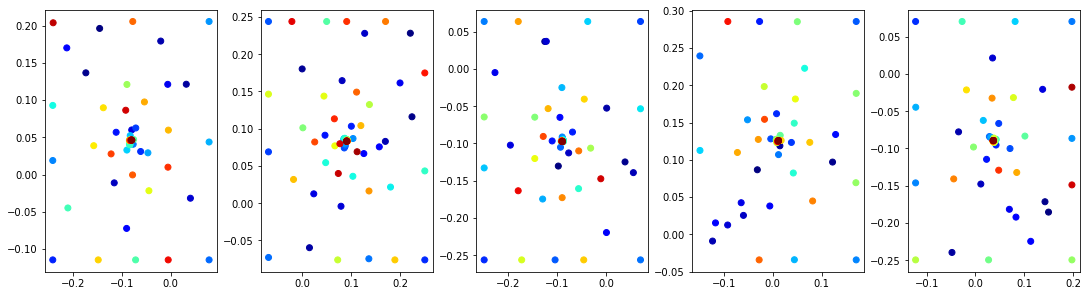

In [112]:
fig, axs = plt.subplots(1, 5, figsize=[15, 4], constrained_layout=True)
axs = axs.flat

nfevals_gp = []
for idx, results_this in enumerate(opt_results_all_gp):
    #yvals_this = opt_results_all_gp[idx][0].func_vals
    xvals_this, yvals_this = np.array(results_this[0].x_iters).T
    nfevals_gp.append(xvals_this.size)
    colors = np.arange(yvals_this.size) / yvals_this.size
    axs[idx].scatter(xvals_this, yvals_this, c=colors, cmap='jet')

In [114]:
final_hists_dws_gp = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams_gp]
final_hists_gp, final_dws_gp = zip(*final_hists_dws_gp)

In [115]:
final_peaks_gp = [dw.get_parameter('peak_intensity') for dw in final_dws_gp]
final_h_fwhms_gp = [dw.get_parameter('h_fwhm') for dw in final_dws_gp]
final_v_fwhms_gp = [dw.get_parameter('v_fwhm') for dw in final_dws_gp]

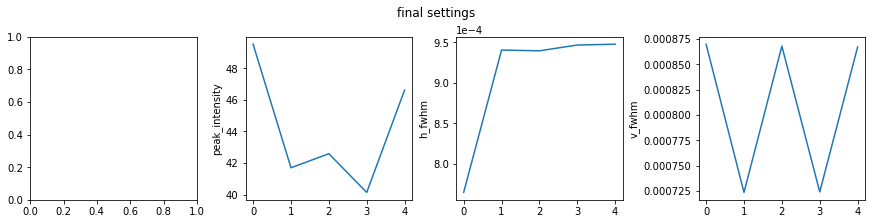

In [116]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

#axes[0].plot(final_centroids)
#axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks_gp)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms_gp)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms_gp)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics_gp.png', bbox_inches='tight')

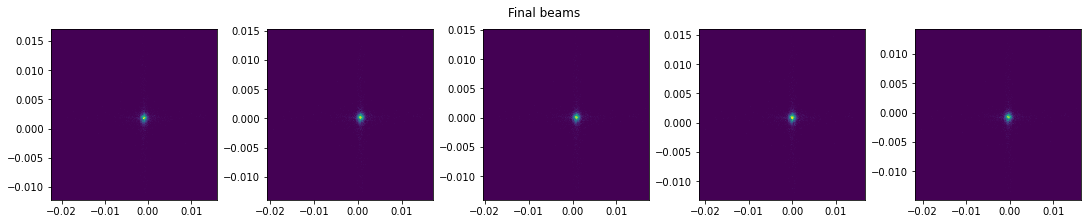

In [117]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists_gp):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams_gp.png', bbox_inches='tight')

#### Alternating optimization with scipy

In [123]:
opt_results[-1].fun

0.0046002452451416615

In [124]:
%%time

def inner_opt(focusing_system, motors, num_iters):
    opt_results_inner = []
    for inner in range(num_iters):
        for mot in zip(motors):
            print(f"Starting inner iteration {inner}, motor {mot}.")
            
            opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=mot, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='centroid', 
                                              loss_min_value=1e-3,
                                              default_opt_params={'maxfev':10, 'disp': True})
    
            opt_results, guesses, solution, _ = opt_trial.trials(verbose=True, guess_min=0, guess_max=0, accept_all_solutions=True)
            focusing_system = opt_trial.focusing_system
            opt_results_inner.append(opt_results)
            if opt_results[-1].fun < opt_trial._loss_min_value:
                print("Optimization successful. Terminating both inner and outer iteration")
                return focusing_system, opt_results_inner, True
    return focusing_system, opt_results_inner, False

overall_successes_alt = []
final_losses_alt = []
final_out_beams_alt = []
opt_results_all_alt = []

min_trans = -0.14
max_trans = 0.14

for outer, test_absolute_movements in tqdm(enumerate(absolute_movements)):
    print("Initial motor positions are", test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    focusing_system, opt_results_inner, success = inner_opt(focusing_system, move_motors, 5)
    
    overall_successes_alt.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    final_losses_alt.append(centroid)
    final_out_beams_alt.append(out_beam)
    opt_results_all_alt.append(opt_results_inner)
    print(f'Test {outer} success {success} with final x {opt_results_inner[-1][-1].x} and final value {opt_results_inner[-1][-1].fun}')

0it [00:00, ?it/s]

Initial motor positions are [ 0.08153128 -0.04539434]
Starting inner iteration 0, motor ('vkb_4',).
Alternating optimization for motor ('vkb_4',)
Initial loss is 0.09301584326050917
initial guess is [0.]
motors ('vkb_4',) trans [0.] current loss 0.09301584326050917
motors ('vkb_4',) trans [0.00025] current loss 0.09323367127522796
motors ('vkb_4',) trans [-0.00025] current loss 0.09279796780072706
motors ('vkb_4',) trans [-0.00075] current loss 0.09236427029261066
motors ('vkb_4',) trans [-0.0015] current loss 0.09171569880792753
motors ('vkb_4',) trans [-0.003] current loss 0.09042033569620679
motors ('vkb_4',) trans [-0.00525] current loss 0.08849095280748845
motors ('vkb_4',) trans [-0.00975] current loss 0.08467636340554324
motors ('vkb_4',) trans [-0.0165] current loss 0.07908474831787808
motors ('vkb_4',) trans [-0.03] current loss 0.06850599478358478
Starting inner iteration 0, motor ('hkb_4',).
Alternating optimization for motor ('hkb_4',)
Initial loss is 0.06850599478358478
in

1it [04:24, 264.46s/it]

Test 0 success False with final x [-0.0165] and final value 0.0010830963020280737
Initial motor positions are [-0.09036973 -0.08380041]
Starting inner iteration 0, motor ('vkb_4',).
Alternating optimization for motor ('vkb_4',)
Initial loss is 0.12281321578194175
initial guess is [0.]
motors ('vkb_4',) trans [0.] current loss 0.12281321578194175
motors ('vkb_4',) trans [0.00025] current loss 0.12263112106836173
motors ('vkb_4',) trans [0.0005] current loss 0.12244860808694318
motors ('vkb_4',) trans [0.001] current loss 0.12208508504056596
motors ('vkb_4',) trans [0.00175] current loss 0.12154123036160935
motors ('vkb_4',) trans [0.00325] current loss 0.12045977790675437
motors ('vkb_4',) trans [0.0055] current loss 0.11885569575911878
motors ('vkb_4',) trans [0.01] current loss 0.11571464026263778
motors ('vkb_4',) trans [0.01675] current loss 0.11117033031405879
motors ('vkb_4',) trans [0.03025] current loss 0.10280561209976367
Starting inner iteration 0, motor ('hkb_4',).
Alternatin

2it [08:05, 238.64s/it]

Test 1 success True with final x [-0.0075] and final value 0.0004878519860813573
Initial motor positions are [0.08939178 0.09628829]
Starting inner iteration 0, motor ('vkb_4',).
Alternating optimization for motor ('vkb_4',)
Initial loss is 0.130914176391395
initial guess is [0.]
motors ('vkb_4',) trans [0.] current loss 0.130914176391395
motors ('vkb_4',) trans [0.00025] current loss 0.13108352144025515
motors ('vkb_4',) trans [-0.00025] current loss 0.13074507341789682
motors ('vkb_4',) trans [-0.00075] current loss 0.13040825618622132
motors ('vkb_4',) trans [-0.0015] current loss 0.12990398037784115
motors ('vkb_4',) trans [-0.003] current loss 0.12890298619273066
motors ('vkb_4',) trans [-0.00525] current loss 0.12742021110548513
motors ('vkb_4',) trans [-0.00975] current loss 0.124520581182594
motors ('vkb_4',) trans [-0.0165] current loss 0.1203532653966641
motors ('vkb_4',) trans [-0.03] current loss 0.11275528556842446
Starting inner iteration 0, motor ('hkb_4',).
Alternating 

3it [11:38, 227.19s/it]

Test 2 success True with final x [-0.0058125] and final value 0.0005390808326979325
Initial motor positions are [-0.0108506  -0.12566181]
Starting inner iteration 0, motor ('vkb_4',).
Alternating optimization for motor ('vkb_4',)
Initial loss is 0.12594808784728376
initial guess is [0.]
motors ('vkb_4',) trans [0.] current loss 0.12594808784728376
motors ('vkb_4',) trans [0.00025] current loss 0.12592586034447673
motors ('vkb_4',) trans [0.0005] current loss 0.12590507977608817
motors ('vkb_4',) trans [0.001] current loss 0.12586414674942578
motors ('vkb_4',) trans [0.00175] current loss 0.12580711455181898
motors ('vkb_4',) trans [0.00325] current loss 0.1257061134469504
motors ('vkb_4',) trans [0.0055] current loss 0.12558939456960924
motors ('vkb_4',) trans [0.01] current loss 0.125478618698732
motors ('vkb_4',) trans [0.01675] current loss 0.12562034203465122
motors ('vkb_4',) trans [0.0116875] current loss 0.12547949730283656
Starting inner iteration 0, motor ('hkb_4',).
Alternati

4it [15:21, 225.52s/it]

Test 3 success True with final x [0.0049375] and final value 0.00034184390802420784
Initial motor positions are [-0.03739743  0.08965405]
Starting inner iteration 0, motor ('vkb_4',).
Alternating optimization for motor ('vkb_4',)
Initial loss is 0.09681140438651067
initial guess is [0.]
motors ('vkb_4',) trans [0.] current loss 0.09681140438651067
motors ('vkb_4',) trans [0.00025] current loss 0.09671593831991887
motors ('vkb_4',) trans [0.0005] current loss 0.0966216549320258
motors ('vkb_4',) trans [0.001] current loss 0.09643457892458848
motors ('vkb_4',) trans [0.00175] current loss 0.09615832465357081
motors ('vkb_4',) trans [0.00325] current loss 0.09561977523070796
motors ('vkb_4',) trans [0.0055] current loss 0.09485069582524533
motors ('vkb_4',) trans [0.01] current loss 0.09345316739980963
motors ('vkb_4',) trans [0.01675] current loss 0.09175497666674448
motors ('vkb_4',) trans [0.03025] current loss 0.0896748104828379
Starting inner iteration 0, motor ('hkb_4',).
Alternatin

5it [18:11, 218.34s/it]

Test 4 success True with final x [-0.03] and final value 0.0005657643660938349
CPU times: user 17min 30s, sys: 1min 51s, total: 19min 22s
Wall time: 18min 11s


In [ ]:
op

In [131]:
nfevals_alt = []
func_vals_alt = []
for sr_per_outer in opt_results_all_alt:
    nfevals_outer = 0
    func_vals_outer = 0
    for sr_per_guess in sr_per_outer:
        nfevals_outer += sum([sr['nfev'] for sr in sr_per_guess])
        func_vals_outer = sr_per_guess[-1]['fun']
    nfevals_alt.append(nfevals_outer)
    func_vals_alt.append(func_vals_outer)

In [132]:
nfevals_alt

[94, 78, 76, 80, 60]

In [133]:
final_hists_dws_alt = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams_alt]
final_hists_alt, final_dws_alt = zip(*final_hists_dws_alt)

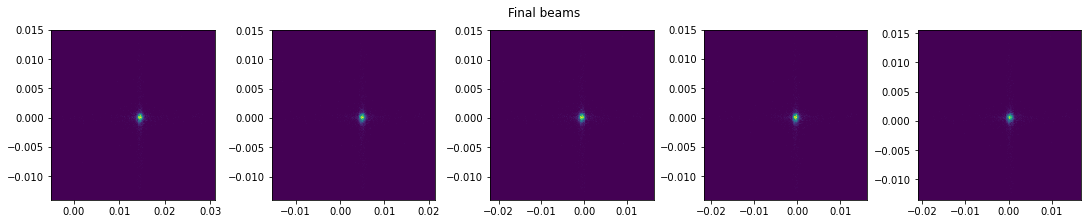

In [134]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists_alt):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams_scipy_alt.png', bbox_inches='tight')

#### Alternating optimization with skopt

In [25]:
callback_y = skopt.callbacks.DeltaYStopper(1e-5)
callback_x = skopt.callbacks.DeltaXStopper(1e-5)

In [ ]:
%%time

    
def inner_opt(focusing_system, motors, bounds_all, num_iters):
    opt_results_inner = []
    for inner in range(num_iters):
        for mot, bound in zip(motors, bounds_all):
            print(f"Starting inner iteration {inner}, motor {mot} with bounds {bound}.")
            
            
            starting_val = movers.get_absolute_positions(focusing_system, mot)
            opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=mot, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='centroid', 
                                              loss_min_value=1e-3)
            opt_trial.set_gaussian_process_optimizer(bounds=[bound], callback=[callback_x, callback_y],
                                                     n_calls=10, n_initial_points=5)
    
            opt_results, guesses, solution, _ = opt_trial.trials(verbose=False, guess_min=0, guess_max=0, accept_all_solutions=True)
            focusing_system = opt_trial.focusing_system
            relative_trans = opt_results[-1].x
            
            new_trans = np.atleast_1d(relative_trans) + np.atleast_1d(starting_val)
            focusing_system = movers.move_motors(focusing_system, mot, new_trans, movement='absolute')
            
            opt_results_inner.append(opt_results)
            if opt_results[-1].fun < opt_trial._loss_min_value:
                print("Optimization successful. Terminating both inner and outer iteration")
                return focusing_system, opt_results_inner, True
    return focusing_system, opt_results_inner, False

overall_successes_alt_gp = []
final_losses_alt_gp = []
final_out_beams_alt_gp = []
opt_results_all_alt_gp = []

min_trans = -0.14
max_trans = 0.14

for outer, test_absolute_movements in tqdm(enumerate(absolute_movements)):
    print("Initial motor positions are", test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    bounds_all_mots = []
    for m in test_absolute_movements:
        bounds_this = [min_trans - m - 0.02, max_trans - m + 0.02]
        bounds_all_mots.append(bounds_this)
    
    focusing_system, opt_results_inner, success = inner_opt(focusing_system, move_motors, bounds_all_mots, 5)
    
    overall_successes_alt_gp.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    final_losses_alt_gp.append(centroid)
    final_out_beams_alt_gp.append(out_beam)
    opt_results_all_alt_gp.append(opt_results_inner)
    print(f'Test {outer} success {success} with final x {opt_results_inner[-1][-1].x} and final value {opt_results_inner[-1][-1].fun}')

0it [00:00, ?it/s]

Initial motor positions are [ 0.08153128 -0.04539434]
Starting inner iteration 0, motor vkb_4 with bounds [-0.24153128, 0.07846872000000002].
Initial loss is 0.09301584326050917


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Loss is 0.045293046162746965 for x [-0.08205283996947671] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 0, motor hkb_4 with bounds [-0.11460566000000001, 0.20539434].
Initial loss is 0.045293046162746965
Loss is 0.002395459092562687 for x [0.047685249793558496] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 1, motor vkb_4 with bounds [-0.24153128, 0.07846872000000002].
Initial loss is 0.0023954590925627443
Loss is 0.01579713699260827 for x [-0.015015064215172846] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 1, motor hkb_4 with bounds [-0.11460566000000001, 0.20539434].
Initial loss is 0.015797170904972492
Loss is 0.01591724763846521 for x [-0.0054088929226236565] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 2, motor vkb_4 with bounds [-0.24153128, 0.07846872000000002].
Initial loss is 0.01591724763846521


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Loss is 0.0030558257844883756 for x [0.015499295711608102] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 2, motor hkb_4 with bounds [-0.11460566000000001, 0.20539434].
Initial loss is 0.0030558257844883756
Loss is 0.014320521998753598 for x [0.017408039212494827] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 3, motor vkb_4 with bounds [-0.24153128, 0.07846872000000002].
Initial loss is 0.014320521998753586
Loss is 0.0158910151220822 for x [-0.006856494614328995] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 3, motor hkb_4 with bounds [-0.11460566000000001, 0.20539434].
Initial loss is 0.015891015122082193
Loss is 0.008412388457661693 for x [-0.019181043059572092] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 4, motor vkb_4 with bounds [-0.24153128, 0.07846872000000002].
Initial loss is 0.008412388457661693
Loss is 0.01038447

1it [04:39, 279.30s/it]

Test 0 success False with final x [0.014710235060147334] and final value 0.013483188589317524
Initial motor positions are [-0.09036973 -0.08380041]
Starting inner iteration 0, motor vkb_4 with bounds [-0.06963027000000002, 0.25036973].
Initial loss is 0.12281321578194175
Loss is 0.08363481049981152 for x [0.09020887299115518] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 0, motor hkb_4 with bounds [-0.07619959000000001, 0.24380041].
Initial loss is 0.08363481049981152
Loss is 0.003714886116495645 for x [0.08745423341477473] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 1, motor vkb_4 with bounds [-0.06963027000000002, 0.25036973].
Initial loss is 0.0037148861164955083


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


Loss is 0.005023748193565592 for x [-0.003257038444443222] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 1, motor hkb_4 with bounds [-0.07619959000000001, 0.24380041].
Initial loss is 0.005023748193565592
Loss is 0.019311437487486937 for x [-0.02271375099365324] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 2, motor vkb_4 with bounds [-0.06963027000000002, 0.25036973].
Initial loss is 0.019311262771560294
Loss is 0.019961216509014754 for x [0.009375174655354007] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 2, motor hkb_4 with bounds [-0.07619959000000001, 0.24380041].
Initial loss is 0.019961216509014765


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Loss is 0.007894140521298523 for x [0.02403862930032423] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 3, motor vkb_4 with bounds [-0.06963027000000002, 0.25036973].
Initial loss is 0.007894140521298523
Loss is 0.016440956193408244 for x [-0.02152358262404796] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 3, motor hkb_4 with bounds [-0.07619959000000001, 0.24380041].
Initial loss is 0.016440956193408247
Loss is 0.015750709650117864 for x [-0.006810282335949047] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 4, motor vkb_4 with bounds [-0.06963027000000002, 0.25036973].
Initial loss is 0.015750709650117864
Loss is 0.013335060294573818 for x [0.0024129751754066314] and min acceptable value is 0.001
Solution is not acceptable.
Starting inner iteration 4, motor hkb_4 with bounds [-0.07619959000000001, 0.24380041].
Initial loss is 0.01333506029457379
Loss is 0.0165778293

2it [09:17, 278.65s/it]

Test 1 success False with final x [-0.0082349381389515] and final value 0.016577829398874123
Initial motor positions are [0.08939178 0.09628829]
Starting inner iteration 0, motor vkb_4 with bounds [-0.24939178, 0.07060822000000001].
Initial loss is 0.130914176391395


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


In [146]:
opt_results_all_alt_gp

[]

In [26]:
shutil.rmtree(temp_work_dir)